Persistence Landscapes in Data Augmentation
---

***Initialization cells***

In [ ]:
import copy
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt

![ -z "$(pip list | grep 'sktime')" ] && pip install sktime
from sktime.utils.load_data import load_from_arff_to_dataframe
from nets import *

# for Maks' imports
![ -z "$(pip list | grep 'giotto-tda')" ] && pip install giotto-tda
from tda_tools import *

In [2]:
mode = 'cnn'  # better not to change to rnn, since cnn is superior
              # mode affects only autoencoder choice and its dataloader
    
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

# Choose which data to upload: univariate or multivariate
multivariate = False
dataset_name = 'Coffee'

# multivariate = True
# dataset_name = 'HandMovementDirection'

In [3]:
def get_batches(X_train, y_train=None, batch_size=3, mode='rnn'):
    if mode == 'rnn':
        ids = torch.randperm(X_train.size(1))
        if y_train is None:
            for bx in X_train[:,ids].chunk(batch_size, 1):
                yield bx
        else:
            for bx,by in zip(
                X_train[:,ids].chunk(batch_size, 1),
                y_train[ids].chunk(batch_size)):
                yield bx,by
    elif mode == 'cnn':
        ids = torch.randperm(len(X_train))
        if y_train is None:
            for bx in X_train[ids].chunk(batch_size):
                yield bx
        else:
            for bx,by in zip(
                X_train[ids].chunk(batch_size),
                y_train[ids].chunk(batch_size)):
                yield bx,by
    else:
        raise TypeError("arg type must be 'cnn' or 'rnn'")

# Preprocessing Part

## Univariate Data

### Data Loading

In [40]:
out = None
if not multivariate:
    # Install and import of https://pypi.org/project/uea-ucr-datasets/
    ![ -z "$(pip list | grep 'Cython')" ] && pip install Cython
    ![ -z "$(pip list | grep 'uea-ucr-datasets')" ] && pip install uea-ucr-datasets

    data_dir = Path('../data')
    data_dir.mkdir(exist_ok=True)
    %env UEA_UCR_DATA_DIR={data_dir}
    import uea_ucr_datasets as ucr_ds


    # Download univariate dataset (preprocessed by sktime)
    url = ('http://www.timeseriesclassification.com/'
           'Downloads/Archives/Univariate2018_ts.zip')
    if not (data_dir/'archive.zip').exists():
        !wget -O {data_dir}/archive.zip {url}


    # Extract files from the archive
    num_files = !ls {data_dir} | wc -l
    if int(num_files[0]) < 130:
        print('not all dataset are present')
        !unzip -qn {data_dir}/archive.zip -d {data_dir}
        !mv -n {data_dir}/Univariate_ts/* {data_dir}
        !rmdir {data_dir}/Univariate_ts 2> /dev/null


    # Data Description
    print('Printing the description of the selected dataset')
    !head -8 {data_dir}/{dataset_name}/{'%s_TRAIN.ts' % dataset_name}

    ds_train= ucr_ds.Dataset(dataset_name, train=True)
    ds_test = ucr_ds.Dataset(dataset_name, train=False)
    print('\nData content (partial display):')
    print('-------------------------------')
    print('time-series labels')
    print(ds_train.data_y)
    print('\ntable with sequences')
    out = ds_train.data_x.head()
    emb_size = 1
out

env: UEA_UCR_DATA_DIR=../data
Printing the description of the selected dataset
#"FoodFood spectrographs are used in chemometrics to classify food types, a task that has obvious applications in food safety and quality assurance. The coffee data set is a two class problem to distinguish between Robusta and Aribica coffee beans. Further information can be found in the original paper Briandet et al. Discrimination of Arabica and Robusta in Instant Coffee by Fourier Transform Infrared Spectroscopy and Chemometrics J. Agricultural and Food Chemistry, 44 (1), 1996. The data was first used in the time series classification literature in Bagnall et al. Transformation Based Ensembles for Time Series Classification, SDM 2012.
@problemName Coffee
@timeStamps false
@missing false
@univariate true
@equalLength true
@seriesLength 286
@classLabel true 0 1

Data content (partial display):
-------------------------------
time-series labels
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1'

,dim_0
0,0 -0.518419 1 -0.485884 2 -0.50500...
1,0 -0.548462 1 -0.533681 2 -0.51472...
2,0 -0.472634 1 -0.415546 2 -0.35992...
3,0 -0.509521 1 -0.484218 2 -0.47795...
4,0 -0.563427 1 -0.533896 2 -0.54382...


---

### Data unpacking

Since the dataset is small, we can load the whole data and slice it into chunks

In [30]:
if not multivariate:
    X = []
    for v in ds_train.data_x.values: X.append(v[0])
    seq_length = len(v[0])
    
    if mode == 'rnn':
        X_train = torch.Tensor(X).permute(1,0)[...,None]
        y_train = torch.LongTensor(ds_train.data_y.astype(int))
    else:
        X_train = torch.Tensor(X)[:,None]
        y_train = torch.LongTensor(ds_train.data_y.astype(int))
    X_train, y_train = X_train.to(device), y_train.to(device)
    
    n_classes = len(torch.unique(y_train))

    X = []
    for v in ds_test.data_x.values: X.append(v[0])
    if mode == 'rnn':
        X_test = torch.Tensor(X).permute(1,0)[...,None]
        y_test = torch.LongTensor(ds_test.data_y.astype(int))
    else:
        X_test = torch.Tensor(X)[:,None]
        y_test = torch.LongTensor(ds_test.data_y.astype(int))
    X_test, y_test = X_test.to(device), y_test.to(device)

## Multivariate Data

Loading all datasets is a pretty heavy procedure.  
So, we download just 2-3 datasets to a local directory and then hook up the right one by its name

### Data unpacking

In [23]:
out = None
if multivariate:
    folder = Path('../multivar_time_series')
    X_train_raw, y_train_raw = load_from_arff_to_dataframe(
        folder/dataset_name/f'{dataset_name}_TRAIN.arff')
    X_test_raw, y_test_raw = load_from_arff_to_dataframe(
        folder/dataset_name/f'{dataset_name}_TEST.arff')

    print(f'\nShape of the training dataset: {X_train_raw.shape}')
    emb_size = X_train_raw.shape[1]
    out = X_train_raw.head()
out


Shape of the training dataset: (160, 10)


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9
0,0 152.472131 1 151.149948 2 133...,0 12.392351 1 77.166998 2 75.53...,0 18.801367 1 7.669297 2 20...,0 119.067984 1 92.378960 2 50...,0 9.371185 1 28.596053 2 33...,0 176.878290 1 134.774572 2 77...,0 187.217536 1 181.612639 2 143...,0 148.597142 1 -7.859846 2 -75...,0 192.406885 1 123.777559 2 37...,0 125.757108 1 -38.720199 2 -86...
1,0 -13.040644 1 12.830811 2 -3...,0 19.233769 1 -4.991483 2 -16...,0 66.933527 1 124.618288 2 98...,0 -35.137874 1 1.701522 2 25...,0 50.791490 1 221.224243 2 252...,0 -154.184133 1 -26.774156 2 45...,0 30.970773 1 148.602671 2 160...,0 -208.111167 1 -192.617816 2 -181...,0 -130.664900 1 -63.905838 2 -15...,0 -195.935521 1 -19.472038 2 56...
2,0 347.753571 1 283.267749 2 242...,0 197.774774 1 150.099303 2 117...,0 63.838660 1 63.824220 2 84...,0 245.984713 1 162.896918 2 108...,0 210.905239 1 144.768204 2 94...,0 280.506386 1 206.246174 2 170...,0 354.705629 1 262.012640 2 168...,0 223.814706 1 122.452679 2 65...,0 207.523094 1 182.589754 2 126...,0 303.975308 1 168.434157 2 65...
3,0 -233.910173 1 -263.752715 2 -250...,0 -187.467394 1 -142.395013 2 -135...,0 -86.571985 1 -47.182563 2 -6...,0 -184.676555 1 -195.306612 2 -141...,0 -108.266154 1 124.377494 2 200...,0 -231.688096 1 -179.703892 2 -97...,0 -262.399832 1 -32.974744 2 89...,0 -105.677538 1 42.209137 2 118...,0 -82.033333 1 -67.506163 2 -82...,0 -140.012384 1 0.278821 2 71...
4,0 109.304340 1 64.749574 2 25...,0 201.260745 1 50.199130 2 -39...,0 14.521665 1 -88.523783 2 -152...,0 195.652441 1 196.864336 2 165...,0 125.077312 1 4.943108 2 -43...,0 211.538165 1 184.857103 2 152...,0 238.791210 1 170.498851 2 137...,0 66.915634 1 147.337646 2 126...,0 69.283736 1 88.357515 2 67...,0 160.787868 1 239.187795 2 229...


In [74]:
if multivariate:
    X = []
    for v in X_train_raw.values:
        X_k = []
        for i in range(emb_size):
            X_k.append(v[i])
        X.append(X_k)
        
    seq_length = len(v[0])
    if mode == 'rnn':
        X_train = torch.Tensor(X).permute(2,0,1)
        y_train = torch.LongTensor(pd.factorize(y_train_raw)[0])
    else:
        X_train = torch.Tensor(X)
        y_train = torch.LongTensor(pd.factorize(y_train_raw)[0])
    X_train, y_train = X_train.to(device), y_train.to(device)
    
    n_classes = len(torch.unique(y_train))

    X = []
    for v in X_test_raw.values:
        X_k = []
        for i in range(emb_size):
            X_k.append(v[i])
        X.append(X_k)
        
    if mode == 'rnn':
        X_test = torch.Tensor(X).permute(2,0,1)
        y_test = torch.LongTensor(pd.factorize(y_test_raw)[0])
    else:
        X_test = torch.Tensor(X)
        y_test = torch.LongTensor(pd.factorize(y_test_raw)[0])
    X_test, y_test = X_test.to(device), y_test.to(device)

## Reducing Dataset

In [163]:
# if you choose more balanced ids, then
# the the load on the balancing step
# in the intra/extra-polation procedure will be mitigated
# Definitely use it if you are going to exclude
# the balancing step from the augmentation part

more_balanced_choice = True

if more_balanced_choice:
    y_train = torch.randint(2, (20,))
    cnts = y_train.bincount()
    inv_cnts = 1./cnts.float()
    inv_cnts /= inv_cnts.sum()
    
    probs = torch.empty(len(y_train))
    for i, weight in enumerate(inv_cnts):
        probs[y_train == i] = weight
else:
    probs = torch.ones(len(y_train))

# select randomly 30% of all samples from the dataset
share = .3

red_ids = torch.multinomial(probs, int(share*len(y_train)))
X_red = X_train[red_ids]
y_red = y_train[red_ids]

## Extracting persistence landscapes

In [ ]:
# Maks' cell
# ----------
# Tunable hyperparameters
n_layers = 1
n_steps = 120

# Extracting test landscapes
data_x=ds_train.data_x
data_y=ds_train.data_y
data_x = data_x.to_numpy()
data_x = np.array([sample[0].to_list() for sample in data_x])
data_torch = torch.FloatTensor(data_x)[:, :, None]
print(np.shape(data_x), np.shape(data_y))

point_clouds_torch = Takens_Embedding_torch(data_torch, d=3, delay=3)
diagrams_torch, diagrams_np, VR_persistence = get_diagrams_torch(point_clouds_torch)
landscapes_torch, max_scale = get_landscapes_torch(diagrams_torch, n_layers, n_steps)

pairwise_distances = landscapes_distances(landscapes_torch, max_scale)
matching_matrix = data_y[:, np.newaxis] == data_y[np.newaxis, :]
kNN_score = get_kNN_score_torch(pairwise_distances, matching_matrix=matching_matrix)

print("Point_clouds shape:", point_clouds_torch.size())
print("Diagrams shape:", diagrams_torch.size())
print("Landscapes shape:", landscapes_torch.size())
print("kNN score:", kNN_score)

land_shape = tuple(landscapes_torch.shape[1:])
landscapes_train = landscapes_torch.to(device)

In [ ]:
# Maks' cell
# ----------

# Extracting train landscapes
data_x=ds_test.data_x
data_y=ds_test.data_y
data_x = data_x.to_numpy()
data_x = np.array([sample[0].to_list() for sample in data_x])
print(np.shape(data_x), np.shape(data_y))

data_torch = torch.FloatTensor(data_x)[:, :, None]

point_clouds_torch = Takens_Embedding_torch(data_torch, d=3, delay=3)
diagrams_torch, diagrams_np, VR_persistence = get_diagrams_torch(point_clouds_torch)
landscapes_torch, max_scale = get_landscapes_torch(diagrams_torch, n_layers, n_steps)

pairwise_distances = landscapes_distances(landscapes_torch, max_scale)
matching_matrix = data_y[:, np.newaxis] == data_y[np.newaxis, :]
kNN_score = get_kNN_score_torch(pairwise_distances, matching_matrix=matching_matrix)

print("Point_clouds shape: ", point_clouds_torch.size())
print("Diagrams shape: ", diagrams_torch.size())
print("Landscapes shape: ", landscapes_torch.size())
print("kNN score: ", kNN_score)

landscapes_test = landscapes_torch.to(device)

# Network Training Procedures

Here you need to define all hyperparameters to achieve sth worthwhile  
For different datasets, they may take different values

In [118]:
# common variable names
best_weights = None
best_score = [float('inf')]
train_history, test_history = [], []

## Auto-encoder's train function

In [ ]:
# Autoencoder tunable hyperparameters:
code_size = 100            # compression level
channels = [32, 64]        # number of neurons in hidden layers 
kernel_size = 46
# last two are valid for 'cnn' only

# Optimizer tunable hyperparameters:
lr = 1e-4
step = 2
gamma = .999

# Here you can choose the loss function
MSE = nn.MSELoss()
MAE = lambda X,Y: (X-Y).abs().mean()
criterion_ae = MAE

# Globally defined variables of the function 'train_*'
if mode == 'rnn':
    ae = RNNSeqAE(emb_size, code_size, seq_length).to(device)
    mode = 'cnn'
else:
    ae = ConvSeqAE(
        emb_size, code_size, seq_length,
        channels, kernel_size).to(device)
    
opt_ae = optim.Adam(ae.parameters(), lr)
sch_ae = optim.lr_scheduler.StepLR(opt_ae, step, gamma)

# training procedure
def train_ae(X_train, num_epochs, mode, verbose=True):
    for epoch in range(num_epochs):
        train_loss = []
        for bx in get_batches(X_train, mode=mode):
            opt_ae.zero_grad()
            bx_rec = ae(bx)
            loss = criterion_ae(bx_rec, bx)
            loss.backward()
            train_loss.append(loss.item())
            opt_ae.step()
        sch_ae.step()
        train_history.append(np.mean(train_loss))
        test_loss = criterion_ae(ae(X_test), X_test).item()
        test_history.append(test_loss)
        if verbose:
            print(f'Epoch #{epoch}\n------')
            print(train_history[-1])
            print(test_history[-1], '\n')
        if test_loss < best_score[0]:
            best_score[0] = test_loss
            best_weights = copy.deepcopy(ae.state_dict())

## Classifier's train function

In [36]:
# Classifier tunable hyperparameters:
channels = [2, 4, 8]        # number of neurons in hidden layers 
kernel_size = 7

# Optimizer tunable hyperparameters:
lr = 1e-2
step = 2
gamma = .999

# Globally defined variables of the function 'train_*'
clf = SeqClassifier(
    emb_size, n_classes,
    channels, kernel_size).to(device)
opt_clf = optim.Adam(clf.parameters(), lr)
sch_clf = optim.lr_scheduler.StepLR(opt_clf, step, gamma)
criterion_clf = nn.CrossEntropyLoss()

# training procedure
def train_clf(X_train, y_train, num_epochs, mode, verbose=True):
    for epoch in range(num_epochs):
        train_loss = []
        for bx,by in get_batches(X_train, y_train, mode=mode):
            opt_clf.zero_grad()
            y_pred = clf(bx)
            loss = criterion_clf(y_pred, by)
            loss.backward()
            train_loss.append(loss.item())
            opt_clf.step()
        sch_clf.step()
        train_history.append(np.mean(train_loss))
        test_loss = criterion_clf(clf(X_test), y_test).item()
        test_history.append(test_loss)
        if verbose:
            print(f'Epoch #{epoch}\n------')
            print(train_history[-1])
            print(test_history[-1], '\n')
        if test_loss < best_score[0]:
            best_score[0] = test_loss
            best_weights = copy.deepcopy(clf.state_dict())

## Landscape Inverse's train function

In [76]:
# Landscape Inverse tunable hyperparameters
channels = [32, 64]

# Optimizer tunable hyperparameters
lr = 1e-4
step = 2
gamma = .999

# Choose the loss function here
MSE = nn.MSELoss()
MAE = lambda X,Y: (X-Y).abs().mean()
criterion_pli = MAE

# Globally defined variables of the function 'train_*'
pli = LandscapeInverse(emb_size, land_shape, seq_length, channels)
opt_pli = optim.Adam(pli.parameters(), lr)
sch_pli = optim.lr_scheduler.StepLR(opt_pli, step, gamma)

# training procedure
def train_pli(landscapes_train, num_epochs, mode, verbose=True):
    train_ids = torch.arange(len(landscapes_train))
    for epoch in range(num_epochs):
        train_loss = []
        for bx,ids in get_batches(landscapes_train, train_ids, mode=mode):
            opt_pli.zero_grad()
            bx_rec = pli(bx)
            loss = criterion_pli(bx_rec, X_train[ids])
            loss.backward()
            train_loss.append(loss.item())
            opt_pli.step()
        sch_pli.step()
        train_history.append(np.mean(train_loss))
        test_loss = criterion_pli(pli(landscapes_test), X_test).item()
        test_history.append(test_loss)
        if verbose:
            print(f'Epoch #{epoch}\n------')
            print(train_history[-1])
            print(test_history[-1], '\n')
        if test_loss < best_score[0]:
            best_score[0] = test_loss
            best_weights = copy.deepcopy(pli.state_dict())

## SAE with persistence landscapes' train function

In [ ]:
length = 286  # series length
emb_size = 1  # dimensionality of series element
code_size = 100  # compression level

slae = TDASAE(emb_size, code_size, length, land_shape, [32, 64])
opt_slae = optim.Adam(slae.parameters(), 1e-4)
sch_slae = optim.lr_scheduler.StepLR(opt_slae, 2, .999)

MSE = nn.MSELoss()
MAE = lambda X,Y: (X-Y).abs().mean()
criterion_slae = MAE

# training procedure
def train_slae(X_train, num_epochs, mode, verbose=True):
    train_ids = torch.arange(len(X_train))
    for epoch in range(num_epochs):
        train_loss = []
        for bx,ids in get_batches(X_train, train_ids, mode=mode):
            opt_slae.zero_grad()
            bx_rec = slae(bx, landscapes_train[ids])
            loss = criterion_slae(bx_rec, bx)
            loss.backward()
            train_loss.append(loss.item())
            opt_slae.step()
        sch_slae.step()
        train_history.append(np.mean(train_loss))
        test_loss = criterion_slae(slae(X_test, landscapes_test), X_test).item()
        test_history.append(test_loss)
        if verbose:
            print(f'Epoch #{epoch}\n------')
            print(train_history[-1])
            print(test_history[-1], '\n')
        if test_loss < best_score[0]:
            best_score[0] = test_loss
            best_weights = copy.deepcopy(slae.state_dict())

## Other tools

In [113]:
def clear_buffers(best_score, list1, list2):
    best_score[0] = float('inf')
    list1.clear(); list2.clear()

In [167]:
def oversampling(X, y, augments, k=3, sign=-1):
    """
    X   array of shape (batch_size, code_length);
        to apply to persistence landscape, you must 
        reshape it first
    
    sign = -1 -> intrapolation
    sign = +1 -> extrapolation
    """
    new_X, new_y = [], []
    for lbl, m in enumerate(augments):
        X_lbl = X[y==lbl]
        m_ids = torch.multinomial(
            torch.ones(len(X_lbl)), m, replacement=True)
        lambda_ = X.new(m).uniform_(.3, .7)[:, None, None]
        
        mX_lbl = X_lbl[m_ids]
        mk_ids = torch.norm(
            X_lbl - mX_lbl[:,None], dim=2
        ).topk(k, dim=1)[1]
        
        new_X.append(
            (lambda_*sign*(mX_lbl[:,None]-X_lbl[mk_ids])
             + mX_lbl[:,None]).flatten(0,1))
        new_y.append(torch.tensor([lbl]*m*k))
    return torch.cat(new_X), torch.cat(new_y)

# Results Reproduction of DeVries and etc 

## Training autoencoder

In [116]:
best_weights = clear_buffers(best_score, train_history, test_history)

In [ ]:
train_ae(X_red, 100, mode, verbose=False)

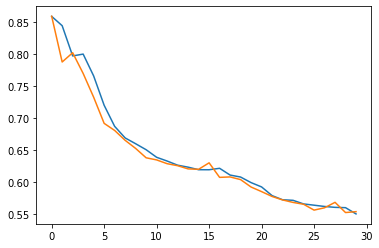

In [160]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='test')
plt.title("Autoencoder's Loss")
plt.legend();

In [27]:
# Load best weights
if best_weights:
    sae.load_state_dict(best_weights)
    
# And check the reconstruction
perm_ids = torch.randperm(X_test.size(1))
sae(X_red[:,perm_ids]).squeeze(), X_red[:,perm_ids].squeeze()

(tensor([[-0.5871, -0.5939, -0.6055,  ..., -0.5989, -0.5627, -0.5252],
         [-0.5540, -0.5606, -0.5718,  ..., -0.5654, -0.5305, -0.4943],
         [-0.5494, -0.5570, -0.5701,  ..., -0.5626, -0.5221, -0.4801],
         ...,
         [-1.8614, -1.8478, -1.8245,  ..., -1.8378, -1.9100, -1.9847],
         [-1.8533, -1.8388, -1.8140,  ..., -1.8282, -1.9050, -1.9846],
         [-1.8330, -1.8193, -1.7956,  ..., -1.8091, -1.8822, -1.9580]],
        grad_fn=<SqueezeBackward0>),
 tensor([[-0.5723, -0.6629, -0.6653,  ..., -0.5213, -0.5985, -0.6303],
         [-0.5737, -0.6550, -0.6368,  ..., -0.4891, -0.5762, -0.5871],
         [-0.6026, -0.6347, -0.6397,  ..., -0.5139, -0.6023, -0.5301],
         ...,
         [-1.8439, -1.8251, -1.7937,  ..., -1.8122, -1.9104, -2.0121],
         [-1.8455, -1.8269, -1.7953,  ..., -1.8136, -1.9118, -2.0148],
         [-1.8467, -1.8284, -1.7969,  ..., -1.8147, -1.9125, -2.0159]]))

## Training classifier on reduced dataset

In [ ]:
train_clf(X_red, y_red, 30, mode, verbose=False)

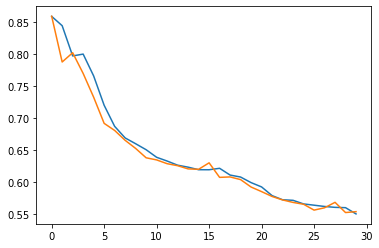

In [160]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='test')
plt.title("Classifier's Loss")
plt.legend();

In [40]:
y_pred = clf.predict(X_test) 
print('accuracy =', accuracy_score(y_test, y_pred))
y_test, y_pred

(tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]))

## Applying transformations to extracted code

In [ ]:
code = sae.enc(X_train).detach()
X_augmented, y_augmented = [], []

# Balance the number of class representators
cnts = y_train.bincount()
augments = cnts.max().item() - cnts
if any(augments):
    new_code, new_y = oversampling(code, y_train, augments)
    new_X = sae.dec(new_code).detach()
    X_augmented.append(new_X)
    y_augmented.append(new_y)
    
M = 10  # chose M: <!! each class will grow by M !!>
# Equal augmentation
augments = [M] * len(cnts)
new_code, new_y = oversampling(code, y_train, augments)
new_X = sae.dec(new_code).detach()
X_augmented.append(new_X)
y_augmented.append(new_y)

X_augmented, y_augmented = map(torch.cat, (X_augmented, y_augmented))

In [159]:
# Data augmentation by adding gaussian noise

# !! Take into consideration that noise here is being applied
# to balanced and already augmented by inter/extra-polation dataset !!

code = sae.enc(X_augmented).detach()
new_code = code + .05*torch.randn_like(code)
X_augmented = torch.cat([X_augmented, sae.dec(new_code).detach()])
y_augmented = torch.cat([y_augmented, y_augmented])

## Training classifier on augmented dataset

In [ ]:
train_clf(X_augmented, y_augmented, 30, mode, False)

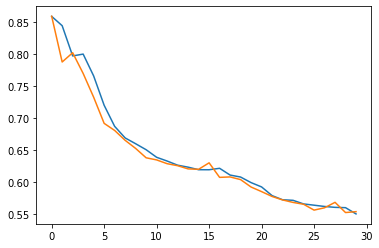

In [160]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='test')
plt.title("Classifier's Loss")
plt.legend();

In [40]:
y_pred = clf.predict(X_test) 
print('accuracy =', accuracy_score(y_test, y_pred))
y_test, y_pred

(tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]))

# Augmentation with Persistence Landscapes

## Scheme 1

In [77]:
train_pli(1, mode)

Epoch #0
------
0.827996551990509
0.799287736415863 



## Scheme 2

In [147]:
train_slae(1, mode)

Epoch #0
------
0.841687003771464
0.8316600322723389 



---